In [2]:
import numpy as np
from scipy.signal import medfilt
from astropy.io import fits

import sys
sys.path.insert(1, '../python/')
from gspice import *

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

from time import time
from tqdm import tqdm 

## Read in files

In [3]:
#synthstars1 = fits.open("/global/cscratch1/sd/tanveerk/desi/simspec/std-input-spectra_5000.fits")
#synthstars2 = fits.open("/global/cscratch1/sd/tanveerk/desi/simspec/std-input-spectra_5000v2.fits")
#synthstars1_obs = fits.open("/global/cscratch1/sd/tanveerk/desi/simspec/std-observed-spectra_5000.fits")
synthstars = fits.open("/global/cfs/cdirs/desi/users/dfink/gspice/testDvec.fits")

## Visualize spectra

In [4]:
#wavelength grid for LAMOST data
wvGrid = 3750.0 * 10**(1e-4 * np.arange(3801)) 

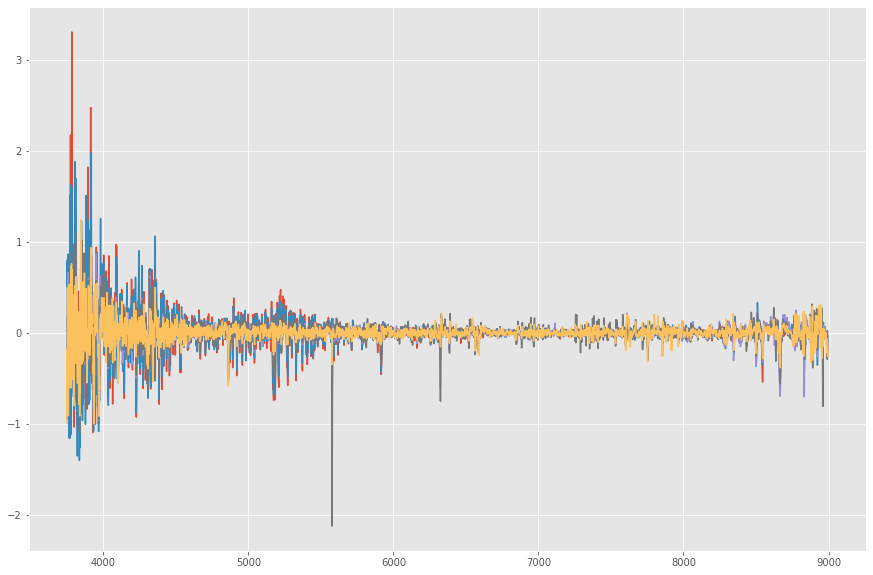

In [4]:
plt.figure(figsize = (15, 10))
for i in range(5):
    plt.plot(wvGrid, synthstars[0].data[i])

In [5]:
#read in covariance matrix and visualize
cov_doug = fits.open("/global/cfs/cdirs/desi/users/dfink/gspice/testcov.fits")[0].data

#plt.figure(figsize = (10, 7))
#sns.heatmap(cov_doug[:1000, :1000], cmap = 'seismic')

Check condition number of covariance matrix

In [13]:
np.linalg.cond(cov_doug)

25491892.336672977

Read in RMS of spectra

In [11]:
refrms = fits.open("/global/cfs/cdirs/desi/users/dfink/gspice/testrefrms.fits")

In [12]:
refrms.info()

Filename: /global/cfs/cdirs/desi/users/dfink/gspice/testrefrms.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (237512,)   float32   


Combine input spectra files

In [9]:
#purespectra = np.vstack((synthstars1[1].data, synthstars2[1].data))
purespectra = synthstars[0].data

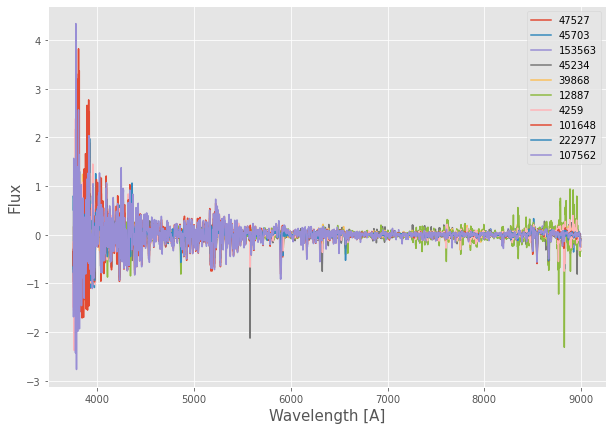

In [10]:
fsize = (10,7)
fs = 15

tmp_idx = np.random.choice(purespectra.shape[0], size = 10, replace = False)
plt.figure(figsize=fsize)
for i in range(len(tmp_idx)):
    plt.plot(wvGrid, purespectra[i], label = f'{tmp_idx[i]}')
#plt.ylim([-20, 40])
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Flux", fontsize = fs)
plt.legend(loc = 'best')

In [16]:
def continuum_normalize(wave, flux, flux_weight, med_filt_size = 301, D = 2):
    """
    Applies median filter to 1D spectrum and returns continuum
    normalized spectrum by fitting polynomial of order D.
    
    Parameters
    ----------
    wave : 1D numpy array, size M
        wavelength grid for the spectrum
    flux : 1D numpy array, size M
        flux grid for the spectrum
    weight : 1D numpy array, size M
        weight grid for the spectrum, pass 1/sigma for Gaussian 
        uncertainties
    med_filt_size : odd number
        kernel size for median filtering ~flux~ object
    D : number
        order of polynomial fit
        
    Returns
    -------
    flux_normalized : 1D numpy array, size M
        normalized flux grid for the spectrum
    """
    
    flux_filtered = medfilt(flux, kernel_size=med_filt_size)
    #a, b, c = np.polyfit(x = wave, y = flux_filtered, deg = D, w = flux_weight)
    
    #flux_fitted = a * wave**2 + b * wave + c
    
    flux_normalized = flux/(flux_filtered)
    
    return flux_normalized## Functions to preprocess dataset

In [11]:
def scale_flux(flux_normalized, scale_factor):
    """
    Scales normalized flux by scale_factor.
    
    Parameters
    ----------
    flux_normalized : n-D numpy array, size N x M
        normalized flux grid for the spectrum
    scale_factor : 1D numpy array, size M
        scale factor per spectra 
    
    Returns
    -------
    flux_scaled : n-D numpy array, size N x M
        scaled flux grid for the spectrum
    
    Notes
    -----
    Test ~flux_g~ with FLUX_R, FIBERFLUX_R and SNR_RED 
    and study the differences.
    """
    flux_scaled = scale_factor[:,np.newaxis] * flux_normalized
    return flux_scaled

In [12]:
def mean_subtract(flux_scaled, flux_weight = None, weighted = True):
    """
    Returns mean subtracted spectra. 
    
    Parameters
    ----------
    flux_scaled : n-D numpy array, size N x M
        scaled spectrum flux grid
    flux_weight : n-D numpy array, size N x M
        spectrum weights 
    weighted : bool
        whether to calculate weighted mean
        
    Returns
    -------
    flux_mean_subtracted : n-D numpy array, size M
        mean subtracted spectrum
    """
    
    if(weighted):
        mean = np.average(a = flux_scaled, axis = 1, weights = flux_weight)
    else:
        mean = np.mean(a = flux_scaled, axis = 1)
        
    flux_mean_subtracted = flux_scaled - mean[:,np.newaxis]
    
    return flux_mean_subtracted

In [13]:
def preprocess(wave, flux, flux_weight, scale_factor, med_filt_size = 151, \
               D = 2, weighted = True):
    """
    Preprocesses data by normalizing, scaling and mean subtracting.
    
    Parameters
    ----------
    wave : n-D numpy array, size N X M
        wavelength grid
    flux : n-D numpy array, size N X M
        observed flux grid 
    flux_weight : n-D numpy array, size N X M
        weight for flux vector; generally ivar of observed flux
    scale_factor : 1D numpy array, size M
        scale factor per spectra
    med_filt_size : odd number
        kernel size for median filtering ~flux~ object
    D : number
        order of polynomial fit
    weighted : bool
        whether to calculate weighted mean
        
    Returns
    -------
    flux_normalized : n-D numpy array, size N X M
        normalized flux grid for the spectrum
    flux_scaled : n-D numpy array, size N x M
        scaled flux grid for the spectrum
    flux_mean_subtracted : n-D numpy array, size M
        mean subtracted spectrum
    """
    
    flux_normalized = np.zeros(flux.shape) 
    
    for i in range(len(flux_normalized)):
        if((i % 1000) == 0):
            print(i)
        flux_normalized[i] = continuum_normalize(wave, flux[i], flux_weight[i]**0.5)
    
    flux_scaled = scale_flux(flux_normalized, scale_factor)
    flux_mean_subtracted = mean_subtract(flux_scaled, flux_weight, weighted = False)
    
    return flux_normalized, flux_scaled, flux_mean_subtracted

Run Preprocessing

In [15]:
pixmin = 0; pixmax = -1 #reduce features for curse of dimensionality

starwave = np.float64(synthstars[0].data[pixmin:pixmax])
starflux = np.float64(purespectra[:, pixmin:pixmax])
starivar = np.float64(np.ones(starflux.shape))
starsnr_r = np.float64(np.ones(starflux.shape[0]))

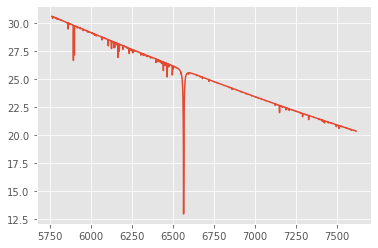

In [16]:
plt.plot(starwave, starflux[10])

In [17]:
tmpflux_filtered = medfilt(starflux[10], kernel_size=301)

(6500, 6600)

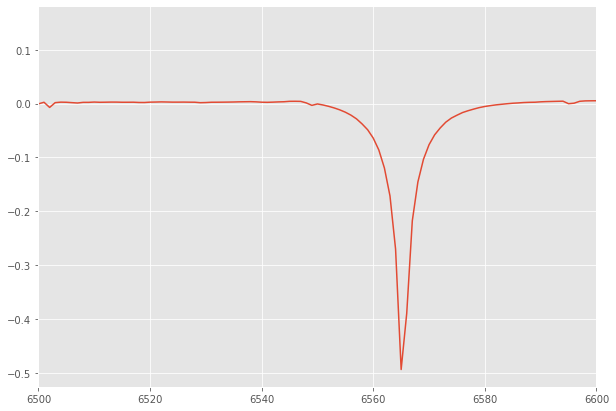

In [18]:
plt.figure(figsize=fsize)
plt.plot(starwave, starflux[10]/tmpflux_filtered - 1)
plt.xlim([6500, 6600])

In [19]:
%time starflux_normalized, starflux_scaled, starflux_mean_subtracted = preprocess(starwave, starflux, starivar, starsnr_r, med_filt_size=301)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
CPU times: user 5min 19s, sys: 670 ms, total: 5min 20s
Wall time: 5min 21s


Sanity check

In [20]:
# for plotting purposes smooth data 
def smoothing(data, kernel_size = 10):
    kernel = np.ones(kernel_size) / kernel_size
    data_convolved = np.convolve(data, kernel, mode='same')
    
    return data_convolved

Text(0, 0.5, 'Flux')

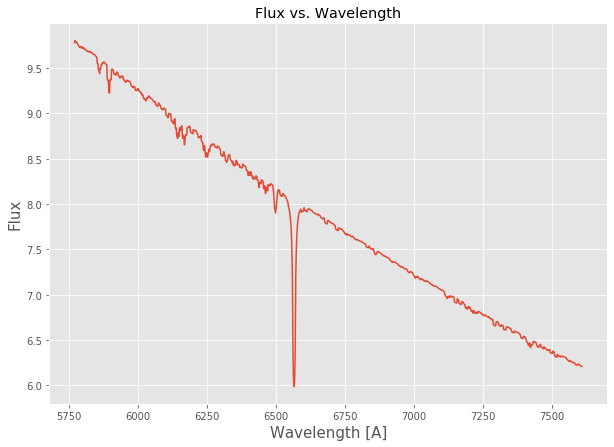

In [21]:
padding = 10 #pixels at extremeties excluded from plotting

i = 67
plt.figure(figsize=fsize)
plt.plot(starwave[padding:-padding], smoothing(starflux[i])[padding:-padding])
plt.title("Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Flux", fontsize = fs)

In [22]:
from specutils.fitting import fit_generic_continuum
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
spectrum = Spectrum1D(flux=starflux[i]*u.Jy, spectral_axis=starwave*u.AA)

In [23]:
gfit = fit_generic_continuum(spectrum)
yfit = gfit(starwave*u.AA)

In [24]:
spec_normalized = spectrum / yfit

Standard Deviation: 0.0006474816762698176


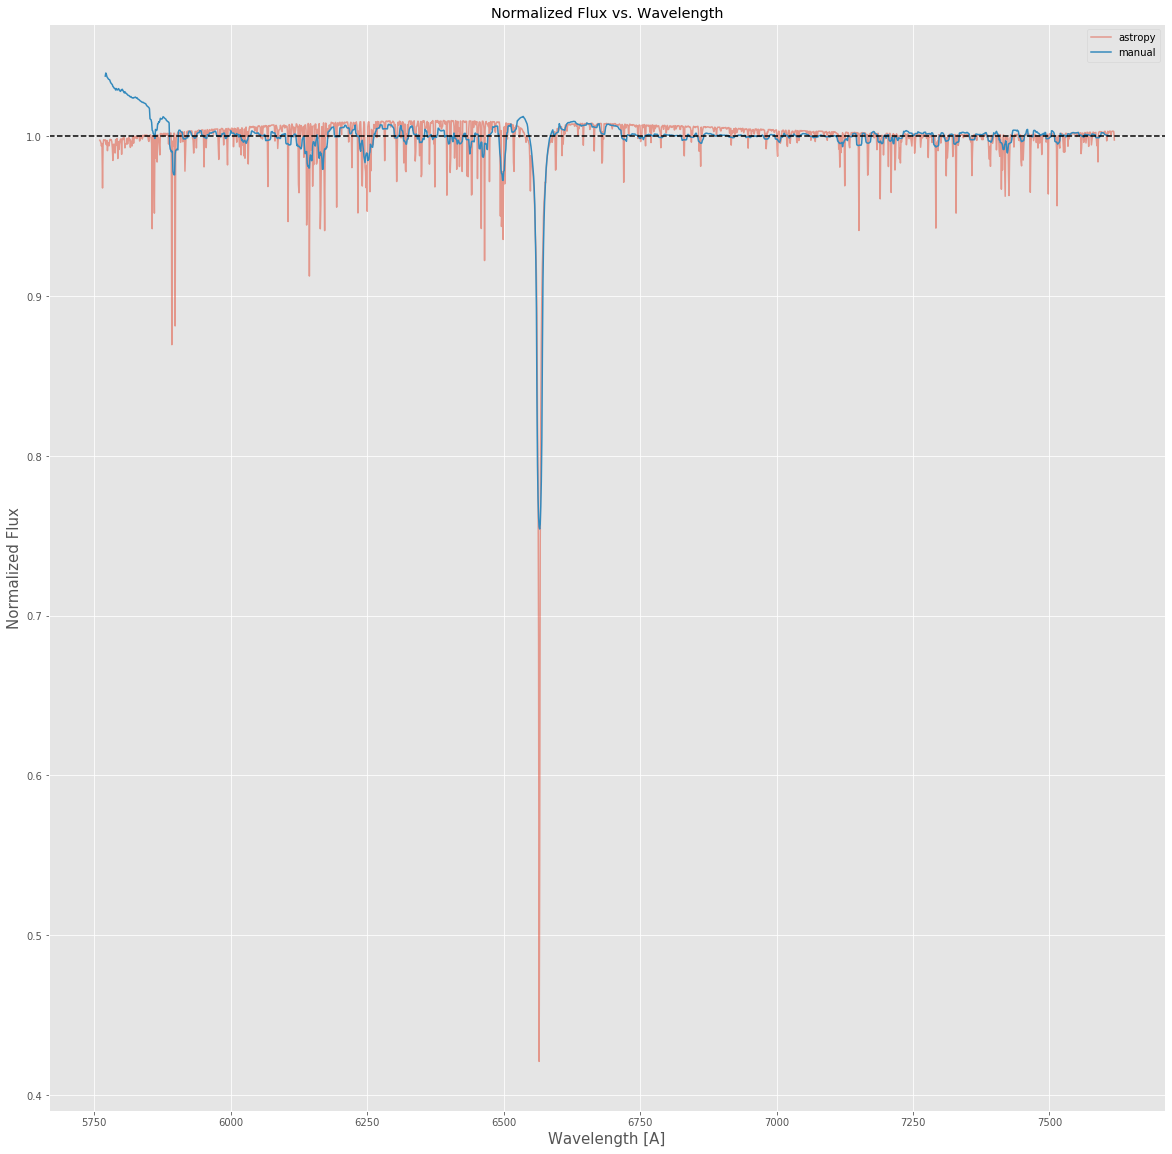

In [25]:
plt.figure(figsize=(20, 20))
plt.plot(spec_normalized.spectral_axis, spec_normalized.flux, label = 'astropy', alpha = 0.5)  
plt.plot(starwave[padding:-padding], smoothing(starflux_normalized[i])[padding:-padding], label = 'manual', alpha = 1)
plt.title("Normalized Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Normalized Flux", fontsize = fs)
plt.axhline(1, c = 'k', ls = '--')
plt.legend(loc = 'best')
print(f"Standard Deviation: {np.var(starflux_normalized[i])}")

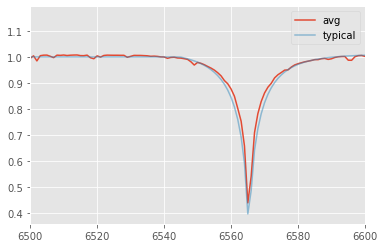

In [26]:
plt.plot(starwave, starflux_normalized.mean(axis = 0), label = 'avg')
plt.plot(starwave, starflux_normalized[1000], alpha = 0.5, label = 'typical')
plt.xlim([6500, 6600])
plt.legend(loc = 'best')

In [84]:
tmpmean = np.mean(starflux_normalized[i])
tmpmean
tmpmeanspectra = starflux_normalized.mean(axis = 0)

(array([1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
        8.000e+00, 2.000e+01, 4.900e+01, 2.909e+03]),
 array([0.83823067, 0.85460145, 0.87097223, 0.887343  , 0.90371378,
        0.92008456, 0.93645534, 0.95282612, 0.9691969 , 0.98556768,
        1.00193846]),
 <a list of 10 Patch objects>)

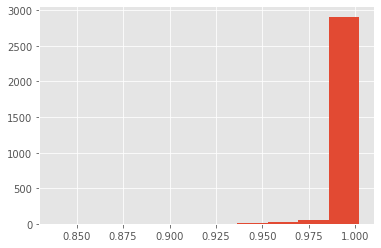

In [72]:
plt.hist(starflux_normalized[i])

In [69]:
1 - tmpmean

0.0011943001473379011

In [27]:
plt.figure(figsize=(20, 20))
#plt.plot(spec_normalized.spectral_axis, spec_normalized.flux, label = 'astropy', alpha = 0.5)  
plt.plot(starwave[padding:-padding], (smoothing(starflux_normalized[i]) - tmpmean)[padding:-padding], label = 'manual', alpha = 1)
plt.plot(starwave[padding:-padding], (smoothing(starflux_normalized[i]) - tmpmeanspectra)[padding:-padding], label = 'means pectra', alpha = 0.5)
#plt.plot(starwave, smoothing(starflux_mean_subtracted[i]), label = 'Unweighted', alpha = 0.9)
plt.title("Normalized Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Normalized Flux", fontsize = fs)
#plt.axhline(1, c = 'k', ls = '--')
plt.legend(loc = 'best')
plt.axhline(1 - tmpmean, c = 'blue', ls = '--')
print(f"Standard Deviation: {np.var(starflux_normalized[i])}")

NameError: name 'tmpmean' is not defined

<Figure size 1440x1440 with 0 Axes>

Standard Deviation of unweighted: 0.0006474816762698175


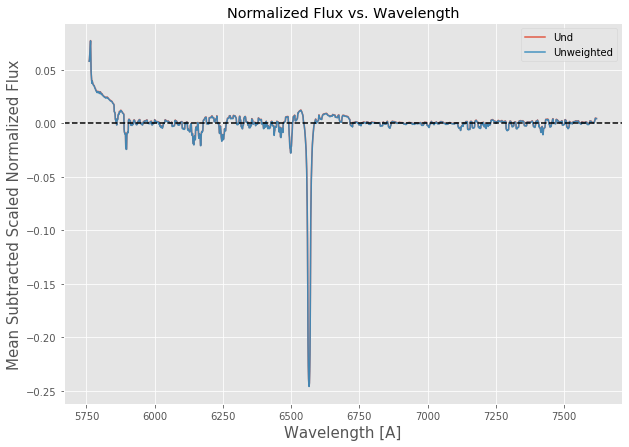

In [30]:
plt.figure(figsize=fsize)
plt.plot(starwave, smoothing(starflux_scaled[i] - 1), label = 'Und', alpha = 0.9)
plt.plot(starwave, smoothing(starflux_mean_subtracted[i]), label = 'Unweighted', alpha = 0.9)
plt.title("Normalized Flux vs. Wavelength")
plt.xlabel("Wavelength [A]", fontsize = fs)
plt.ylabel("Mean Subtracted Scaled Normalized Flux", fontsize = fs)
plt.axhline(0, c = 'k', ls = '--')
plt.legend(loc = 'best')
print(f"Standard Deviation of unweighted: {np.var(starflux_mean_subtracted[i])}")

## Covariance Matrix Estimation

In [31]:
start = time()
#cov = starflux_mean_subtracted.T @ starflux_mean_subtracted
cov = purespectra.T @ purespectra #LAMOST data
tottime = time() - start

print(f"Time took to calculate covariance matrix with data matrix of size {purespectra.shape}: {tottime} seconds.")

Time took to calculate covariance matrix with data matrix of size (237512, 3801): 2337.0078403949738 seconds.


In [16]:
start = time()
#cov_np = np.cov(starflux_mean_subtracted.T)
cov_np = np.cov(purespectra.T)
tottime = time() - start

#print(f"Time took to calculate covariance matrix with data matrix of size {starflux_mean_subtracted.shape}: {tottime} seconds.")
print(f"Time took to calculate covariance matrix with data matrix of size {purespectra.shape}: {tottime} seconds.")

Time took to calculate covariance matrix with data matrix of size (237512, 3801): 65.35995054244995 seconds.


In [18]:
#check condition number of the two covariance matrices
print(cov_np.shape)
print(np.linalg.cond(cov_np))
print(np.linalg.cond(cov_doug))

(3801, 3801)
10477524.05937487
25491892.336672977


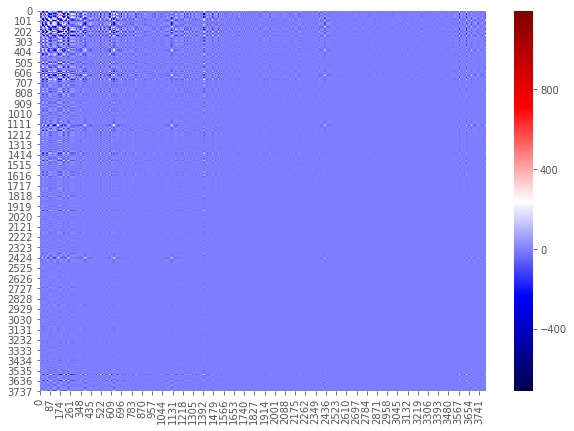

In [19]:
plt.figure(figsize = fsize)

#plot difference of the cov matrices as correlation plot
sns.heatmap(cov_doug - cov_np, cmap = 'seismic')

In [36]:
#condition number
print(np.linalg.cond(cov))
print(np.linalg.cond(cov_np))

5.93723852776662e+21
6.806915526657468e+20


In [21]:
icov = np.linalg.inv(cov_doug)
prod = cov_doug @ icov

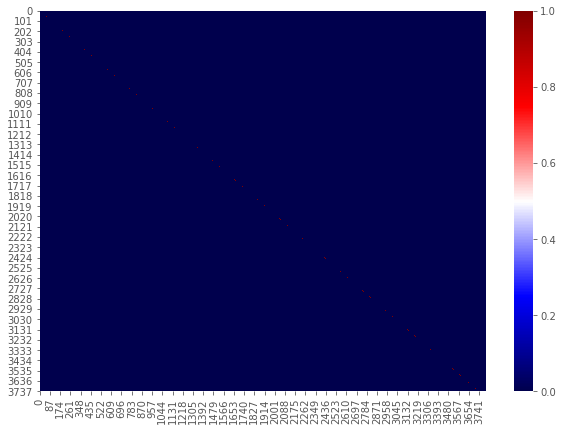

In [22]:
import seaborn as sns
plt.figure(figsize = fsize)
sns.heatmap(prod, cmap = 'seismic')

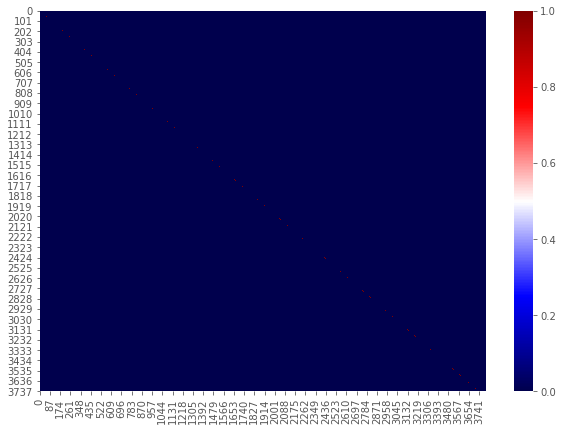

In [23]:
icov_np = np.linalg.inv(cov_np)
prod_np = cov_np @ icov_np
plt.figure(figsize = fsize)
sns.heatmap(prod_np, cmap = 'seismic')

Fix with shrinkage method in `scikit-learn`

Toy example

In [41]:
from sklearn.covariance import ShrunkCovariance
from sklearn.datasets import make_gaussian_quantiles
#real_cov = np.array([[.8, .3],
#                     [.3, .4]])
#rng = np.random.RandomState(0)
#X = rng.multivariate_normal(mean=[0, 0],
#                                  cov=real_cov,
#                                  size=500)
#cov = ShrunkCovariance().fit(X)

In [42]:
cov_shrink = ShrunkCovariance().fit(starflux_mean_subtracted)

In [43]:
np.linalg.cond(cov_shrink.covariance_)

11884.962073397443

In [24]:
corr_shrink.min()

-0.4384323275639369

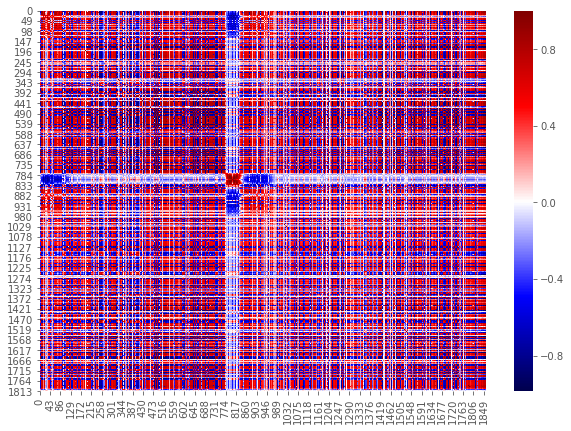

In [45]:
Dinv_shrink = np.diag(1 / np.sqrt(np.diag(cov_shrink.covariance_))) 
corr_shrink = Dinv_shrink @ cov_shrink.covariance_ @ Dinv_shrink

plt.figure(figsize = fsize)
sns.heatmap(corr_shrink, cmap = 'seismic')

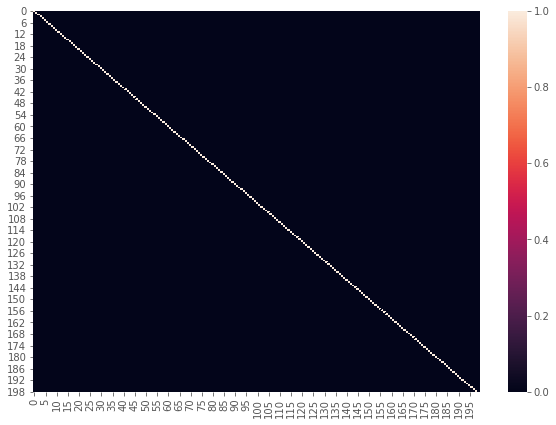

In [46]:
icov_shrink = np.linalg.inv(cov_shrink.covariance_)
prod_shrink = cov_shrink.covariance_ @ icov_shrink
plt.figure(figsize = fsize)
sns.heatmap(prod_shrink[:200, :200])

In [34]:
counter = 0
bad_i = []; bad_j = [] #store indices of non-symmetric values

for i in range(cov.shape[0]):
    if((i % 1000) == 0):
            print(i)
    for j in range(cov.shape[1]):
        if((cov[i,j] - cov[j,i]) == 0.00):
            pass
        else:
            counter += 1
            bad_i.append(i)
            bad_j.append(j)

0
1000


In [35]:
print(f"Total number of elements in the covariance matrix is {cov.shape[0]} X {cov.shape[0]} = {cov.shape[0]**2}.")
print(f"Total number of non-symmetric elements in the covariance matrix is {counter}.")
print(f"Percentage of elements that are non-symmetric: {counter/cov.shape[0]**2 * 100}.")

Total number of elements in the covariance matrix is 2000 X 2000 = 4000000.
Total number of non-symmetric elements in the covariance matrix is 0.
Percentage of elements that are non-symmetric: 0.0.


Correlation matrix

In [50]:
Dinv = np.diag(1 / np.sqrt(np.diag(cov))) 
corr = Dinv @ cov @ Dinv

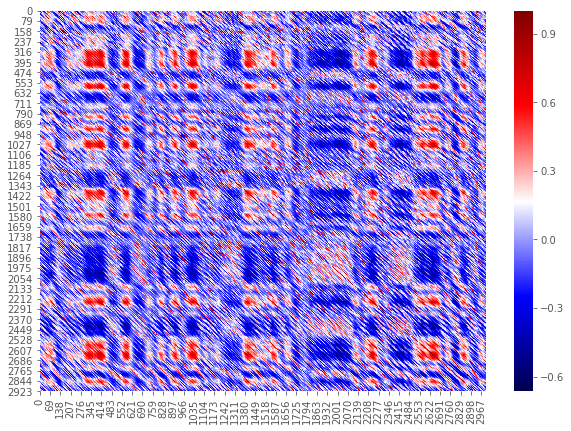

In [51]:
plt.figure(figsize = fsize)
sns.heatmap(corr, cmap = 'seismic')

##### Check corr matrix around the absorption feature of 6500 A

Apply `GSPICE`

In [35]:
starflux_mean_subtracted.shape

(10000, 9300)

In [37]:
cov_shrink.covariance_.shape

(9300, 9300)

## Profiling code

In [16]:
%load_ext line_profiler

ModuleNotFoundError: No module named 'line_profiler'

In [43]:
import numpy as np
import sys
from scipy import linalg
from scipy.linalg import lapack
from time import time as systime  # IDL function is "systime()"



# Invert a positive semi-definite matrix using Cholesky
def cholesky_inv(M):

    # Lower-triangular Cholesky factorization of M    
    L = np.linalg.cholesky(M)

    # Call LAPACK dpotri to get inverse (only lower triangle populated)    
    Minv0 = lapack.dpotri(L, lower=True)[0]

    # Copy lower triangle to upper triangle    
    Minv = Minv0+Minv0.T-np.diag(Minv0.diagonal())
    return Minv



# NAME:
#   submatrix_inv
#
# PURPOSE:
#   Given M and Minv, compute inverse of a submatrix of M
# 
# CALLING SEQUENCE:
#   Ainv = submatrix_inv(M, Minv, imask, bruteforce=False)
#
# INPUTS:
#   M      - (Nd,Nd) parent matrix, assumed symmetric and 
#            positive semi-definite.
#   Minv   - inverse of M, usually calculated with MKL Cholesky routines.
#            this must be passed.
#   imask  - mask of rows/columns to use (1=keep, 0=remove).  This
#            vector contains Nk ones and Nr zeros. 
#   
# OUTPUTS:
#   Ainv   - Inverse of the submatrix of M
#
# EXAMPLES:
#   See gspice routines
#   
# COMMENTS:
#   Let M by a block matrix
#
#          | A   B |                      | P   Q |
#     M  = |       |      and    M^{-1} = |       |
#          | B^T D |                      | Q^T U |
#
#   Then the inverse of submatrix A is the Schur complement of U,
#       
#     A^{-1} = P - Q U^{-1} Q^T
#
#   U and M must be invertible and positive semi-definite.
# 
# REVISION HISTORY:
#   2019-Oct-20 - Written by Douglas Finkbeiner, CfA   (At MPIA)
#   2019-Nov-11 - More compact form for A inverse
#   2020-May-27 - Translated to Python
#
#----------------------------------------------------------------------
def submatrix_inv(M, Minv, imask, bruteforce=False):

    # check dimensions of inputs
    Ndim = len(imask)
    Mdim = M.shape
    
    if (Mdim[0] != Mdim[1]):
        print('M must be a square matrix', file=sys.stderr)
        sys.exit()

    if (Ndim != Mdim[0]):
        print('M and imask have incompatible dimensions', file=sys.stderr)
        sys.exit()

    # rows/columns to keep (k) and remove (r)
    k    = np.array(imask) == 1
    nk   = np.sum(k)

    r    = np.array(imask) == 0
    nr   = np.sum(r)
    
    # brute force option, for testing
    if bruteforce:
        A    = (M[:, k])[k, :]
        Ainv = cholesky_inv(A)
        return Ainv

    # if there is nothing to do, return early
    if nr==0:
        print('imask does not remove any rows/columns...')
        return Minv

    #Uinv = np.linalg.inv((Minv[r,:])[:,r])
    Uinv = np.linalg.inv((Minv[r,:])[:,r])
    #Qt   = (Minv[r, :])[:,k]
    Q    = Qt.T
    #Ainv = (Minv[:, k])[k, :] - np.dot(Q, np.dot(Uinv, Qt))
    
    return Ainv




# NAME:
#   submatrix_inv_mult
#
# PURPOSE:
#   Given M, Minv, and MinvY, compute inverse of submatrix of M, times Y
# 
# CALLING SEQUENCE:
#   Ainvy = gspice_submatrix_inv_mult(M, Minv, imask, Y, MinvY, 
#           irange=, pad=, bruteforce=)
#
# INPUTS:
#   M      - (Nd,Nd) parent matrix, assumed symmetric and 
#            positive semi-definite
#   Minv   - inverse of M, usually calculated with MKL Cholesky routines.
#            this must be passed.
#   imask  - mask of rows/columns to use (1=keep, 0=remove).  This
#            vector contains Nk ones and Nr zeros. 
#   Y      - Matrix (Nspec,Nd) to multiply Ainv by (Nspec can be 1)
#   MinvY  - Minv times Y
#
#
# KEYWORDS:
#   irange - if imask=0 is contiguous, just give endpoints (faster)
#   pad    - zero-pad removed rows of Ainvy to Nd dimensions
#   bruteforce - brute force calculation for validation
#
# OUTPUTS:
#   Ainvy  - Inverse A (submatrix of M) times Y (Nspec, Nd-Nr)
#          - if pad is set, then zero-padded to (Nspec, Nd)
#             (with a zero at each removed row)
#
# EXAMPLES:
#   See gspice routines
#   
# COMMENTS:
#   Let M by a block matrix
#
#          | A   B |                      | P   Q |
#     M  = |       |      and    M^{-1} = |       |
#          | B^T D |                      | Q^T U |
#
#   Then the inverse of submatrix A is the Schur complement of U,
#       
#     A^{-1} = P - Q U^{-1} Q^T
#
#   U and M must be invertible and positive semi-definite.
#   This function returns 
#
#     A^{-1} Y = P Y - Q U^{-1} Q^T Y
#
#   Y is assumed to be zero-padded, i.e. Y[imask == 0]=0
#
# REVISION HISTORY:
#   2019-Oct-20 - Written by Douglas Finkbeiner, CfA   (At MPIA)
#   2019-Nov-11 - More compact form for A inverse
#   2020-May-27 - Translated to Python
#
# TODO:
#   implement irange keyword
#
#----------------------------------------------------------------------
def submatrix_inv_mult(M, Minv, imask, Y, MinvY, irange=1, pad=True, bruteforce=False):

    # check dimensions of inputs
    Ndim = len(imask)
    Mdim = M.shape
    
    if (Mdim[0] != Mdim[1]):
        print('M must be a square matrix', file=sys.stderr)
        sys.exit()

    if (Ndim != Mdim[0]):
        print('M and imask have incompatible dimensions', file=sys.stderr)
        sys.exit()

    if len(Y.shape) != 2:
        print('Y must be a column vector (or array)', file=sys.stderr)
        sys.exit()
        
    if len(MinvY.shape) != 2:
        print('MinvY must be a column vector (or array)', file=sys.stderr)
        sys.exit()
        

    # count rows/columns to keep (k) and remove (r)
    k    = np.array(imask) == 1
    nk   = np.sum(k)

    r    = np.array(imask) == 0
    nr   = np.sum(r)
    
    # brute force option (Slow - use only for testing!)
    if bruteforce:
        A     = (M[:, k])[k, :]
        Ainv  = cholesky_inv(A)
        Ainvy = np.dot(Ainv, Y[k, :])
        return Ainvy


    # if there is nothing to do, return early
    if nr==0:
        print('imask does not remove any rows/columns...')
        return MinvY


# -------- this is much faster if r indices are consecutive, pass irange
#     Use that Qty = Minv y - U y.  Qt is faster to gather than Q.

#  if keyword_set(irange) then begin 
#     U    = Minv[irange[0]:irange[1], irange[0]:irange[1]]
#     Yr   = Y[*, irange[0]:irange[1]]
#     Qty  = Minvy[*, irange[0]:irange[1]] - U ## Yr
#     Qt   = Minv[k, irange[0]:irange[1]]
#  endif else begin 
    U    = (Minv[r,:])[:, r]
    Yr   = Y[r, :]
    Qty  = MinvY[r, :] - np.dot(U, Yr)


# evaluate  A^{-1} Y = P Y - Q U^{-1} Q^T Y

# foolproof way
#    Uinv    = cholesky_inv(U)
#    UinvQtY = np.dot(Uinv, Qty)   

# Faster for big U (and fast enough for small U)
    if U.shape[0] == 1:
        UinvQtY = Qty/U[0]
    else:
        L = linalg.cho_factor(U, lower=False, check_finite=False)
        UinvQtY = linalg.cho_solve(L, Qty, overwrite_b=False)


    # -------- Evaluate   A^{-1} Y = P Y - Q U^{-1} Q^T Y
    # -------- with some shortcuts, using P Y = Minv Y - Q Y

    Qt   = (Minv[r,:])[:, k]   # This line takes most of the time ?!?!?


    #print('MinvY', MinvY.shape)
    #print('Qt', Qt.shape)
    #print('UinvQtY', UinvQtY.shape)
    if pad:
        AinvY0 = np.copy(MinvY)
        AinvY0[k, :] -= np.dot(Qt.T,UinvQtY+Yr)
        AinvY0[r, :] = 0
        return AinvY0

    AinvY = MinvY[k, :]- ( np.dot((UinvQtY+Yr).T, Qt) ).T

    return AinvY


#===================================================




def gaussian_estimate(wavekeep, wavemask, cov, Dvec, covinv, kstar=False, bruteforce=False, nomult=False):
# -------- wavemask is 1 for pixels to be predicted
# --------   conditional on the reference pixels specified by wavekeep

# -------- get index lists forxs reference (k) and interpolation inds
#          (kstar), following notation of RW Chapter 2 ~ Eq. 2.38

    single = len(Dvec.shape) == 1
    sz     = Dvec.shape

    k      = np.array(wavekeep) == 1       # where you have data
    nk     = np.sum(k)
    kstar  = np.array(wavemask) == 1       # where you want to interpolate
    nkstar = np.sum(kstar)



    if bruteforce:   # use old code
        cov_kk         = (cov[k, :])[:, k]
        cov_kkstar     = (cov[kstar, :])[:, k] #  dim [nk, nkstar] ????
        cov_kstark     = (cov[k, :])[:, kstar]
        cov_kstarkstar = (cov[kstar, :])[:, kstar]
        print(cov_kk)
# -------- Choleksy inversion is fine here and much faster than SVD. 
        icov_kk = cholesky_inv(cov_kk)
        cov_kk  = 0   # save memory

# -------- compute the prediction covariance (See RW, Chap. 2)
        print('cov_kstarkstar cov_kkstar icov_kk cov_kstark')
        print(cov_kstarkstar)
        print(cov_kkstar)
        print(icov_kk)
        print(cov_kstark)
        predcovar = cov_kstarkstar - (cov_kkstar.dot(np.dot(icov_kk,cov_kstark)))

        if single:       # multiple parts 2 and 3 first
            predkstar = cov_kkstar.dot(np.dot(icov_kk, Dvec[k].T))
        else:

# -------- compute icov_kk times cov_kstark 

            temp    = cov_kkstar.dot(icov_kk)
            icov_kk = 0
        
            if nkstar == 1:
                temp2     = np.zeros(sz[0])
                temp2[k]  = temp
                predkstar = Dvec.dot(temp2.T)
            else:
                predkstar = Dvec[k, :].dot(temp.T) # this takes memory ## Maybe not in Python?
                print('Using memory intensive code....')


    else:             # -------- GSPICE version

        cov_kkstar     = (cov[kstar, :])[:, k]   #  [nkstar, nk]
        #cov_kkstar     = cov[kstar, k]   #  [nkstar, nk]
        #cov_kkstar     = (cov[:, kstar])[k, :]
        #cov_kkstar     = (cov[kstar, :])[:, k]
        #print(cov_kkstar.shape)
        #cov_kstark     = (cov[k, :])[:, kstar]
        #print(cov_kstark.shape)
        cov_kstark     = cov_kkstar.T
        cov_kstarkstar = (cov[kstar, :])[:, kstar]
        #cov_kstarkstar = cov[kstar, kstar]
        
        
# -------- compute icov_kk times cov_kstark using GSPICE routine
     # could set Minvy for a slight speedup
        #Y = cov[:, kstar]
        Y = cov[kstar,:].T
        Minvy = covinv.dot(Y)


        Ainvy0 = submatrix_inv_mult(cov, covinv, wavekeep, Y, Minvy)
                                # Ainvy is icov_kk ## cov_kstark
                                # Ainvy0 is that zero padded

        predkstar = Dvec.dot(Ainvy0)  # this takes all the time. 
        predoverD = Ainvy0

# -------- compute the prediction covariance (See RW, Chap. 2)
#     predcovar = cov_kstarkstar - (cov_kkstar##(icov_kk##cov_kstark))
        predcovar = cov_kstarkstar - (Y.T).dot(Ainvy0)

    return predkstar, predcovar, predoverD





# Loop over pixels, do pixelwise prediction
def pixelwise_estimate(Dvec, cov, range=False, nguard=20):
    """
    Pixelwise Gaussian Conditional Estimation
    
    Parameters
    ----------
    Dvec : flux matrix
    cov : covariance matrix 
    rang : 
    nguard : size of guard window
    
    Returns
    -------
    pred : GSPICE flux matrix (same dim as Dvec)
    predvar : 
    """
    # Check inputs
    Ndim  = cov.shape
    if (Dvec.ndim == 1): Dvec=Dvec.reshape(1, len(Dvec))
    sz    = Dvec.shape
    npix  = sz[1]
    nspec = sz[0]
    print('pixelwise_estimate:  npix, nspec=', npix, nspec)
    
    if (Ndim[0] != Ndim[1]):
        print('cov must be a square matrix', file=sys.stderr)
        sys.exit()

    if (npix != Ndim[0]):
        print('Dvec and cov have incompatible dimensions', file=sys.stderr)
        sys.exit()

    # range of pixels to estimate
    if range:
        i0 = range[0]
        i1 = range[1]+1  # more Pythonic this way
    else:
        i0 = 0
        i1 = npix

    # allocate output arrays
    szpred = i1-i0
    predvar   = np.zeros((nspec, szpred))
    predoverD = np.zeros((npix,  szpred))

    t0 = systime()

    # -------- compute inverse covariance
    covinv  = cholesky_inv(cov)

    # -------- loop over spectral pixels
    for i in np.arange(i0, i1):

        # -------- wavemask is 1 for pixels to be predicted ...
        wavemask = np.zeros(npix, dtype=np.uint8)
        wavemask[i] = 1

        # -------- conditional on the reference pixels specified by wavekeep
        wavekeep = np.ones(npix, dtype=np.uint8)
        j0 = np.max([0,i-nguard])
        j1 = np.min([i+nguard+1,npix])
        wavekeep[j0:j1] = 0

        # -------- call the Gaussian conditional estimate code
        result = gaussian_estimate(wavekeep, wavemask, cov, Dvec, covinv, bruteforce=False, nomult=True)
        predcovar  = result[1]
        predoverD0 = result[2]
        kstar      = i

        predoverD[:, kstar-i0] = predoverD0[:,0]
#        j = np.arange(predcovar.shape[0])
        predvar[:, kstar-i0] = predcovar[0, 0]

        #print(i, systime()-t0)

    # do the matrix multiplication by Dvec all in one step for efficiency
    pred = np.dot(Dvec, predoverD)

    print('Matrix mult:', systime()-t0)

    return pred, predvar

In [7]:
968/10000

0.0968

In [110]:
#pred, predvar = pixelwise_estimate(Dvec = starflux_mean_subtracted, cov = cov_shrink.covariance_)
%lprun -f pixelwise_estimate pixelwise_estimate(Dvec = purespectra[:10000], cov = cov_doug)

pixelwise_estimate:  npix, nspec= 3801 10000
Matrix mult: 968.9691653251648


Timer unit: 1e-06 s

Total time: 968.871 s
File: <ipython-input-103-f09351a1f288>
Function: pixelwise_estimate at line 354

Line #      Hits         Time  Per Hit   % Time  Line Contents
   354                                           def pixelwise_estimate(Dvec, cov, range=False, nguard=20):
   355                                               """
   356                                               Pixelwise Gaussian Conditional Estimation
   357                                               
   358                                               Parameters
   359                                               ----------
   360                                               Dvec : flux matrix
   361                                               cov : covariance matrix 
   362                                               rang : 
   363                                               nguard : size of guard window
   364                                               
   365                 

In [ ]:
%time

Profiling `gaussian_estimate`

In [19]:
%time covinv_doug = cholesky_inv(cov_doug)

CPU times: user 4 s, sys: 543 ms, total: 4.54 s
Wall time: 2.92 s


In [106]:
%time _= np.linalg.inv(cov_doug)

CPU times: user 7.75 s, sys: 516 ms, total: 8.26 s
Wall time: 4.67 s


In [ ]:
 wavemask = np.zeros(npix, dtype=np.uint8)
        wavemask[i] = 1

In [11]:
tmpi = 100
tmp_Dvec = purespectra[:1]
tmp_npix = tmp_Dvec.shape[1]
tmp_wavemask = np.zeros(tmp_npix, dtype=np.uint8)
tmp_wavemask[tmpi] = 1

In [12]:
tmp_nguard = 20
tmp_wavekeep = np.ones(tmp_npix, dtype=np.uint8)
tmpj0 = np.max([0,tmpi - tmp_nguard])
tmpj1 = np.min([tmpi + tmp_nguard + 1, tmp_npix])
tmp_wavekeep[tmpj0:tmpj1] = 0

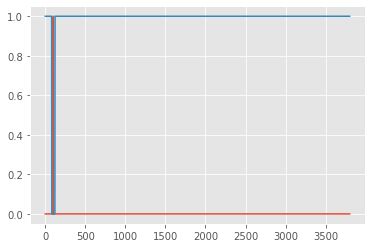

In [13]:
plt.plot(tmp_wavemask)
plt.plot(tmp_wavekeep)

In [17]:
%lprun -f gaussian_estimate gaussian_estimate(tmp_wavekeep, tmp_wavemask, cov_doug, tmp_Dvec, covinv_doug, kstar=False, bruteforce=False, nomult=False)

UsageError: Line magic function `%lprun` not found.


In [48]:
%time tmpval= gaussian_estimate(tmp_wavekeep, tmp_wavemask, cov_doug, tmp_Dvec, covinv_doug, kstar=False, bruteforce=False, nomult=False)

CPU times: user 25.7 ms, sys: 105 ms, total: 131 ms
Wall time: 120 ms


In [82]:
tmpval[0]

array([ True,  True,  True, ...,  True,  True,  True])

In [73]:
tmpval[1]

array([False, False, False, ..., False, False, False])

In [74]:
tmpval[0].shape

(3801,)

In [77]:
%time cov_doug[tmpval[0],:][:,tmpval[1]]

CPU times: user 40.3 ms, sys: 85.9 ms, total: 126 ms
Wall time: 125 ms


array([[408.03975043],
       [459.15021348],
       [408.47960901],
       ...,
       [157.82395616],
       [127.6957854 ],
       [ 58.25189482]])

In [78]:
%time (cov_doug[tmpval[0],:])[:,tmpval[1]]

CPU times: user 28.7 ms, sys: 66.9 ms, total: 95.6 ms
Wall time: 95.2 ms


array([[408.03975043],
       [459.15021348],
       [408.47960901],
       ...,
       [157.82395616],
       [127.6957854 ],
       [ 58.25189482]])

In [60]:
rndmatrix = np.random.randint(0, 10, size = (4, 5))

In [61]:
rndmatrix

array([[8, 0, 1, 8, 9],
       [0, 7, 2, 3, 6],
       [1, 1, 2, 9, 3],
       [6, 8, 0, 8, 7]])

In [64]:
%time rndmatrix[0:2, 0:2]

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 14.1 µs


array([[8, 0],
       [0, 7]])

In [65]:
%time (cov_doug[10, :])[:, 20]

IndexError: too many indices for array

In [66]:
rndmatrix[1, 3]

3

In [55]:
rndmatrix[1,:][:,2]

IndexError: too many indices for array

In [ ]:
(cov[k, :])[:, kstar]

In [25]:
#pred, predvar = pixelwise_estimate(Dvec = starflux_mean_subtracted, cov = cov_shrink.covariance_)
pred, predvar = pixelwise_estimate(Dvec = purespectra[:10], cov = cov_np)

pixelwise_estimate:  npix, nspec= 3801 10
Matrix mult: 323.200119972229


In [26]:
pred.shape

(10, 3801)

In [42]:
np.save("/global/cscratch1/sd/tanveerk/gspice/pred.npy", pred, allow_pickle=False)
np.save("/global/cscratch1/sd/tanveerk/gspice/cov.npy", cov_shrink.covariance_, allow_pickle=False)

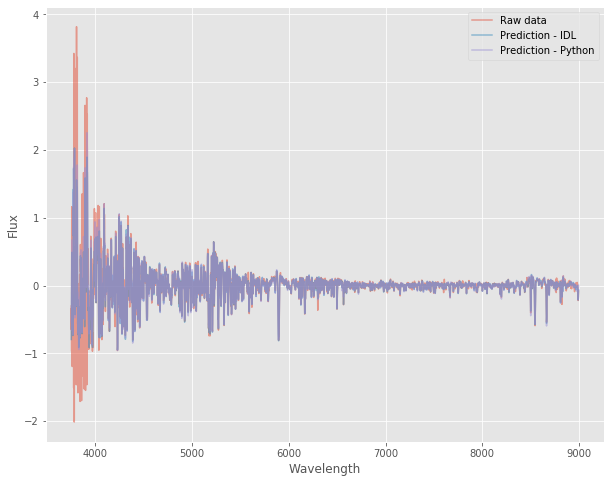

In [39]:
plt.figure(figsize = (10, 8))
i = 7

#for i in range(10):
plt.plot(wvGrid, purespectra[i], label = 'Raw data', alpha = 0.5)
plt.plot(wvGrid, pred_doug[i], label = 'Prediction - IDL', alpha = 0.5)
plt.plot(wvGrid, pred[i], label = 'Prediction - Python', alpha = 0.5)
    #plt.plot(starwave, pred[i], label = 'GSPICE corrected data', alpha = 0.5)
#plt.plot(starwave, pred[i] - starflux_mean_subtracted[i], label = 'Prediction/Data')
    #plt.plot(wvGrid, pred_doug[i], label = 'Prediction/Data')
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend(loc = 'best')
#plt.xlim([6000, 7500])
#plt.ylim([-1000, 1000])

(-1, 1)

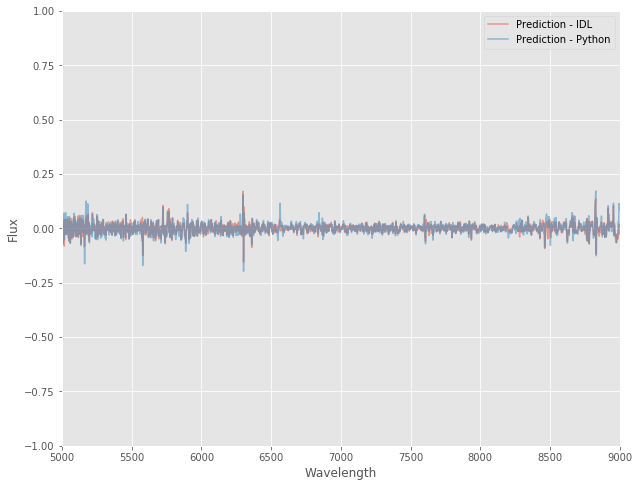

In [47]:
plt.figure(figsize = (10, 8))
i = 7

plt.plot(wvGrid, pred_doug[i] - purespectra[i], label = 'Prediction - IDL', alpha = 0.5)
plt.plot(wvGrid, pred[i] - purespectra[i], label = 'Prediction - Python', alpha = 0.5)
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend(loc = 'best')
plt.xlim([5000, 9000])
plt.ylim([-1, 1])

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(-1000, 1000)

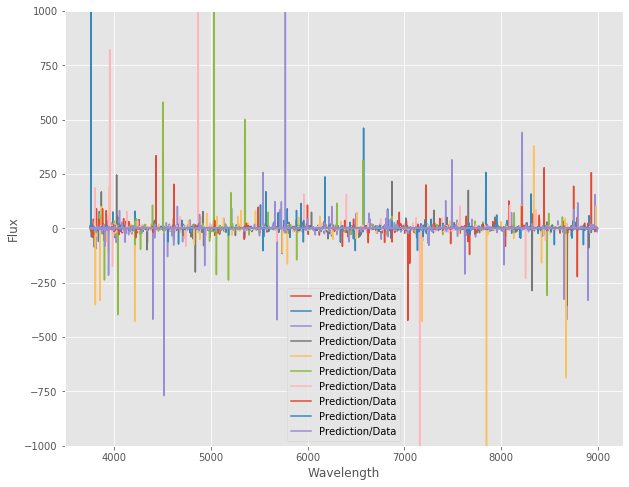

In [34]:
plt.figure(figsize = (10, 8))
i = 1500

for i in range(10):
#plt.plot(starwave[i], starflux[i], label = 'Raw data')
#plt.plot(starwave, starflux_mean_subtracted[i], label = 'Normalized data')
    #plt.plot(starwave, pred[i], label = 'GSPICE corrected data', alpha = 0.5)
#plt.plot(starwave, pred[i] - starflux_mean_subtracted[i], label = 'Prediction/Data')
    plt.plot(wvGrid, pred[i]/purespectra[i], label = 'Prediction/Data')
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend(loc = 'best')
#plt.xlim([6000, 7500])
plt.ylim([-1000, 1000])

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(-1000, 1000)

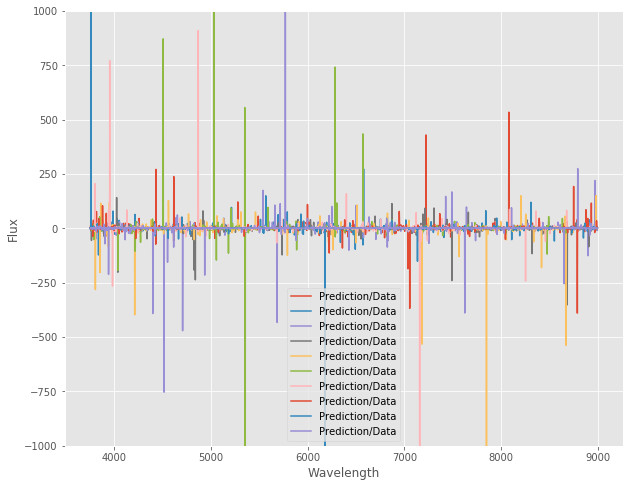

In [35]:
plt.figure(figsize = (10, 8))
i = 1500

for i in range(10):
#plt.plot(starwave[i], starflux[i], label = 'Raw data')
#plt.plot(starwave, starflux_mean_subtracted[i], label = 'Normalized data')
    #plt.plot(starwave, pred[i], label = 'GSPICE corrected data', alpha = 0.5)
#plt.plot(starwave, pred[i] - starflux_mean_subtracted[i], label = 'Prediction/Data')
    plt.plot(wvGrid, pred_doug[i]/purespectra[i], label = 'Prediction/Data')
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend(loc = 'best')
#plt.xlim([6000, 7500])
plt.ylim([-1000, 1000])

(-1000, 1000)

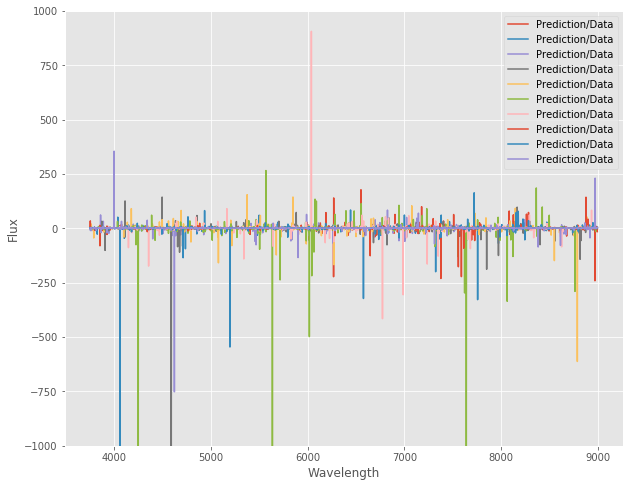

In [36]:
plt.figure(figsize = (10, 8))
i = 1500

for i in range(10):
#plt.plot(starwave[i], starflux[i], label = 'Raw data')
#plt.plot(starwave, starflux_mean_subtracted[i], label = 'Normalized data')
    #plt.plot(starwave, pred[i], label = 'GSPICE corrected data', alpha = 0.5)
#plt.plot(starwave, pred[i] - starflux_mean_subtracted[i], label = 'Prediction/Data')
    plt.plot(wvGrid, pred_doug[i]/pred[i], label = 'Prediction/Data')
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend(loc = 'best')
#plt.xlim([6000, 7500])
plt.ylim([-1000, 1000])